Calculating target Fourier coefficients (phi_k)...
phi_k calculation complete.
Starting simulation...
Step 10/100, Objective: 0.1855
Step 20/100, Objective: 0.0588
Step 30/100, Objective: 0.0759
Step 40/100, Objective: 0.0584
Step 50/100, Objective: 0.0889
Step 60/100, Objective: 0.1144
Step 70/100, Objective: 0.0751
Step 80/100, Objective: 0.0638
Step 90/100, Objective: 0.0494
Step 100/100, Objective: 0.0477
Simulation complete.


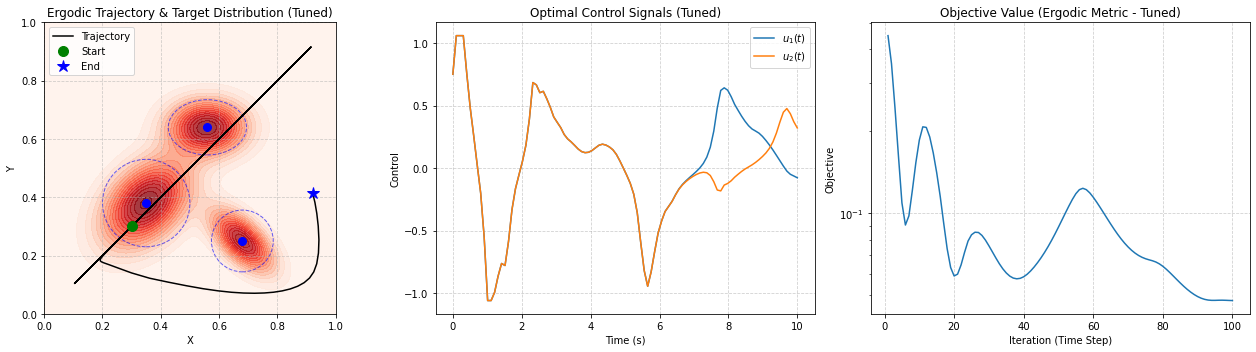

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import comb
import matplotlib.patches as mpatches

# --- 1. Define GMM Parameters and Function ---
w = [0.5, 0.2, 0.3]
mu = [
    np.array([0.35, 0.38]),
    np.array([0.68, 0.25]),
    np.array([0.56, 0.64])
]
Sigma = [
    np.array([[0.01, 0.004], [0.004, 0.01]]),
    np.array([[0.005, -0.003], [-0.003, 0.005]]),
    np.array([[0.008, 0.0], [0.0, 0.004]])
]

gaussians = [multivariate_normal(mean=m, cov=s) for m, s in zip(mu, Sigma)]

def gmm_pdf(x):
    pdf_val = 0
    for weight, gauss in zip(w, gaussians):
        pdf_val += weight * gauss.pdf(x)
    return pdf_val

# --- 2. Define Fourier Basis Functions ---
L = 1.0
N_basis = 10 # Increased N_basis

def get_k_vectors(N_basis, dim=2):
    k_vectors = []
    for i in range(N_basis):
        for j in range(N_basis):
            k_vectors.append(np.array([i, j]))
    return np.array(k_vectors)

k_vectors = get_k_vectors(N_basis)
num_k = len(k_vectors)

def F_k(x, k_vec):
    x = np.clip(x, 0, L)
    return np.prod(np.cos(np.pi * k_vec * x / L))

def grad_F_k(x, k_vec):
    x = np.clip(x, 0, L)
    grad = np.zeros_like(x, dtype=float)
    k1, k2 = k_vec
    x1, x2 = x
    pi_L = np.pi / L

    if k1 != 0:
        grad[0] = -k1 * pi_L * np.sin(k1 * pi_L * x1) * np.cos(k2 * pi_L * x2)
    else:
        grad[0] = 0

    if k2 != 0:
        grad[1] = -k2 * pi_L * np.cos(k1 * pi_L * x1) * np.sin(k2 * pi_L * x2)
    else:
        grad[1] = 0
    return grad

h_k = np.ones(num_k)

def F_k_normalized(x, k_vec, h_val):
    return F_k(x, k_vec) / h_val

def grad_F_k_normalized(x, k_vec, h_val):
    return grad_F_k(x, k_vec) / h_val

# --- 3. Calculate Target Fourier Coefficients (phi_k) ---
print("Calculating target Fourier coefficients (phi_k)...")
grid_size = 100
x_vals = np.linspace(0, L, grid_size)
y_vals = np.linspace(0, L, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
pdf_values = gmm_pdf(grid_points)
dx = L / (grid_size - 1)
dy = L / (grid_size - 1)
dA = dx * dy

phi_k = np.zeros(num_k)
for i, k in enumerate(k_vectors):
    F_k_vals = F_k(grid_points, k)
    h_k_grid = np.sqrt(np.sum(F_k_vals**2) * dA)
    h_k[i] = L if h_k_grid == 0 else h_k_grid
    phi_k[i] = np.sum(pdf_values * (F_k_vals / h_k[i])) * dA

print("phi_k calculation complete.")

# --- 4. Implement Simulation and Control Loop ---
T = 10.0
dt = 0.1
N_steps = int(T / dt)
x0 = np.array([0.3, 0.3])

x_traj = np.zeros((N_steps + 1, 2))
u_traj = np.zeros((N_steps, 2))
obj_value = np.zeros(N_steps)

x_traj[0] = x0
c_k = np.zeros(num_k)

# Control parameters - Adjusted
K_gain = 2.0 # Increased K_gain
U_max = 1.5  # Increased U_max
s_lambda = 1.5
lambda_k = (1.0 + np.linalg.norm(k_vectors, axis=1)**2)**(-s_lambda)
lambda_k[0] = 0

print("Starting simulation...")
for t in range(N_steps):
    xt = x_traj[t]
    current_time = (t + 1) * dt

    F_k_vals_t = np.array([F_k_normalized(xt, k, h) for k, h in zip(k_vectors, h_k)])
    c_k += F_k_vals_t * dt
    c_k_avg = c_k / current_time

    obj_value[t] = np.sum(lambda_k * (c_k_avg - phi_k)**2)

    grad_F_k_vals_t = np.array([grad_F_k_normalized(xt, k, h) for k, h in zip(k_vectors, h_k)])
    
    b_t = np.sum(lambda_k[:, np.newaxis] * (c_k_avg - phi_k)[:, np.newaxis] * grad_F_k_vals_t, axis=0)
    
    u_t = -K_gain * b_t

    norm_u = np.linalg.norm(u_t)
    if norm_u > U_max:
        u_t = u_t * (U_max / norm_u)

    u_traj[t] = u_t
    x_next = xt + u_t * dt
    x_next = np.clip(x_next, 0, L)
    x_traj[t + 1] = x_next
    
    if (t+1) % 10 == 0:
        print(f"Step {t+1}/{N_steps}, Objective: {obj_value[t]:.4f}")

print("Simulation complete.")

# --- 5. Plot Results ---
fig = plt.figure(figsize=(18, 5))

# (1) Ergodic Trajectory
ax1 = fig.add_subplot(131)
ax1.contourf(xx, yy, pdf_values.reshape(xx.shape), levels=20, cmap='Reds', alpha=0.8)
ax1.plot(x_traj[:, 0], x_traj[:, 1], 'k-', lw=1.5, label='Trajectory')
ax1.plot(x_traj[0, 0], x_traj[0, 1], 'go', markersize=10, label='Start')
ax1.plot(x_traj[-1, 0], x_traj[-1, 1], 'b*', markersize=12, label='End')

ax1.set_title('Ergodic Trajectory & Target Distribution (Tuned)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(0, L)
ax1.set_ylim(0, L)
ax1.set_aspect('equal', adjustable='box')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# (2) Optimal Control Signals
ax2 = fig.add_subplot(132)
time_axis = np.linspace(0, T, N_steps)
ax2.plot(time_axis, u_traj[:, 0], label='$u_1(t)$')
ax2.plot(time_axis, u_traj[:, 1], label='$u_2(t)$')
ax2.set_title('Optimal Control Signals (Tuned)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Control')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# (3) Objective Value
ax3 = fig.add_subplot(133)
iteration_axis = np.arange(1, N_steps + 1)
ax3.plot(iteration_axis, obj_value)
ax3.set_title('Objective Value (Ergodic Metric - Tuned)')
ax3.set_xlabel('Iteration (Time Step)')
ax3.set_ylabel('Objective')
ax3.set_yscale('log')
ax3.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()